In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as tdata
import numpy as np

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim

import os
import shutil

def data_loader(data_path, validsize, batchsize = 64, batch_all = True, 
                img_augment = True, GPU = None):
    '''
    A dataloader function for CIFAR10 dataset, inspired by
    https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
    
    transform use:
                randomcrop, randomhorizontalflip, randomrotation [not available in 
                pytorch 0.2.*], totensor, 
                normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)) 
                [discussion about the normalization values used here can be found at
                https://github.com/kuangliu/pytorch-cifar/issues/19];
    batchsize only effective for training set, if batch_all is False; otherwise 
    batchsize for validation and test set is the whole set;
    when using GPU, set pin_memory to True, num_workers will be automatically set to 1;
    randomshuffle is used as default.
    
    return:
            trainloader, whole_trainloader, validloader, testloader
    '''
    
    if GPU == True:
        num_workers = 1
        pin_memory = True
    else:
        num_workers = 4
        pin_memory = False
        
    # Transformation
    if 'CIFAR10' in data_path:
        normalization = transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                             (0.247, 0.243, 0.261))
    else:
        print ('unknown dataset.')
        sys.exit(1)
    
    if img_augment == True:
        train_trans = transforms.Compose([
            transforms.RandomCrop(size = 32, padding = 4),
            transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(degrees = 60.0),
            transforms.ToTensor(),
            normalization
        ])
    else:
        train_trans = transforms.Compose([
            transforms.ToTensor(),
            normalization
        ])
    
    wtrain_trans = transforms.Compose([
        transforms.ToTensor(),
        normalization
    ])
    
    valid_trans = transforms.Compose([
        transforms.ToTensor(),
        normalization
    ])
    
    test_trans = transforms.Compose([
        transforms.ToTensor(),
        normalization
    ])
    
    trainset = torchvision.datasets.CIFAR10(root = data_path, 
                                            train = True, download = True, 
                                            transform = train_trans)
    wtrainset = torchvision.datasets.CIFAR10(root = data_path, 
                                            train = True, download = False, 
                                             transform = wtrain_trans)
    validset = torchvision.datasets.CIFAR10(root = data_path, 
                                            train = True, download = False, 
                                            transform = valid_trans)
    testset = torchvision.datasets.CIFAR10(root = data_path, 
                                            train = False, download = True, 
                                           transform = test_trans)
    
    
    # set shuffle index
    trainsize = len(trainset)
    indices = np.random.permutation(np.arange(trainsize))
    traininds = indices[: (trainsize - validsize)]
    validinds = indices[-validsize: ]
    
    trainsampler = tdata.sampler.SubsetRandomSampler(traininds)
    wtrainsampler = tdata.sampler.SequentialSampler(traininds)
    validsampler = tdata.sampler.SequentialSampler(validinds)
    
    testsize = len(testset)
    wtrainsize = len(wtrainset)
    
    # load data
    trainloader = tdata.DataLoader(trainset, batch_size = batchsize, sampler = trainsampler, 
                                 num_workers = num_workers, pin_memory = pin_memory)
    if batch_all == False:
        wtrainloader = tdata.DataLoader(wtrainset, batch_size = wtrainsize, sampler = wtrainsampler, 
                                 num_workers = num_workers, pin_memory = pin_memory)
        validloader = tdata.DataLoader(trainset, batch_size = validsize, sampler = validsampler, 
                                 num_workers = num_workers, pin_memory = pin_memory)
        testloader = tdata.DataLoader(testset, batch_size = testsize, shuffle = False,
                                      num_workers = num_workers, pin_memory = pin_memory)
    else:
        wtrainloader = tdata.DataLoader(wtrainset, batch_size = batchsize, sampler = wtrainsampler, 
                                 num_workers = num_workers, pin_memory = pin_memory)
        validloader = tdata.DataLoader(trainset, batch_size = batchsize, sampler = validsampler, 
                                 num_workers = num_workers, pin_memory = pin_memory)
        testloader = tdata.DataLoader(testset, batch_size = batchsize, shuffle = False,
                                      num_workers = num_workers, pin_memory = pin_memory)
    
    return (trainloader, wtrainloader, validloader, testloader)


In [2]:
import matplotlib.pyplot as plt

def plot_loss(loss):

	epoch_range = range(1, len(loss[0]) + 1)

	plot1 = plt.plot(epoch_range, loss[0], 'r', linewidth = 1.4, label = 'training_loss')
	plot2 = plt.plot(epoch_range, loss[1], 'g', linewidth = 1.4, label = 'validation_loss')
	plot3 = plt.plot(epoch_range, loss[2], 'b', linewidth = 1.4, label = 'test_loss')

	plt.title('Loss Plot')
	plt.xlabel('Epochs')
	plt.ylabel('loss')
	plt.legend(loc = 'best')
	plt.show()
    
def plot_accu(accuracy):
	
	epoch_range = range(1, len(accuracy[0]) + 1)

	plot1 = plt.plot(epoch_range, accuracy[0], 'r', linewidth = 1.4, label = 'training_accuracy')
	plot2 = plt.plot(epoch_range, accuracy[1], 'g', linewidth = 1.4, label = 'validation_accuracy')
	plot3 = plt.plot(epoch_range, accuracy[2], 'b', linewidth = 1.4, label = 'test_accuracy')

	plt.title('Accuracy(Percent Corrent) Plot')
	plt.xlabel('Epochs')
	plt.ylabel('accuracy')
	plt.legend(loc = 'best')
	plt.show()
    

In [3]:
def training(model, criterion, optimizer, epochs, dataloaders, step_size = None, 
             gamma = None, use_cuda = False, model_dir = None, best_model = False):
    
    print ('start training...')
    
    if model_dir is not None:
        if best_model:
            model_dir = model_dir + '/' + 'best_' + model.__class__.__name__ + '_ckpt.pth.tar'
        else:
            model_dir = model_dir + '/' + model.__class__.__name__ + '_ckpt.pth.tar'
        if os.path.isfile(model_dir):
            print ("loading checkpoint '{}'".format(model_dir))
            checkpoint = torch.load(model_dir)
            start_epoch = checkpoint['epoch']
            stats = checkpoint['stats']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print ("loaded checkpoint '{}' (epoch {})".format(model_dir, checkpoint['epoch']))
            trainstat, validstat, teststat = stats
            if isinstance(step_size, int):
                scheduler = lr_scheduler.StepLR(optimizer = optimizer, step_size = step_size, 
                                                gamma = gamma, last_epoch = (start_epoch - 1))
            elif isinstance(step_size, list):
                scheduler = lr_scheduler.MultiStepLR(optimizer = optimizer, milestones = step_size, 
                                                gamma = gamma, last_epoch = (start_epoch - 1))
            best_valid = np.max(validstat[1])
        else:
            print ("no checkpoint found at '{}'".format(model_dir))
    else:
        start_epoch = 0
        trainstat = [[], []]
        validstat = [[], []]
        teststat = [[], []]
        if isinstance(step_size, int):
            scheduler = lr_scheduler.StepLR(optimizer = optimizer, step_size = step_size, 
                                            gamma = gamma, last_epoch = (start_epoch - 1))
        elif isinstance(step_size, list):
            scheduler = lr_scheduler.MultiStepLR(optimizer = optimizer, milestones = step_size, 
                                            gamma = gamma, last_epoch = (start_epoch - 1))
        best_valid = 0.0
    
    trainloader, wtrainloader, validloader, testloader = dataloaders
    
    for epoch in np.arange(start_epoch, epochs):
    
        if not use_cuda:
            avg_loss = 0.0
            
        if step_size is not None:
            scheduler.step()

        model.train()

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            if use_cuda:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if not use_cuda:
                avg_loss += loss.data[0]

                if i % 100 == 99:
                    print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, avg_loss / 99))
                    avg_loss = 0.0

        model.eval()

        if use_cuda:
            for loader, statlist in [(wtrainloader, trainstat), (validloader, validstat), 
                                     (testloader, teststat)]:
                total = 0
                correct = 0
                batchloss = 0.0
                batchs = 0
                for dataset in loader:
                    inputs, labels = dataset
                    var_inputs, var_labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    outputs = model(var_inputs)
                    batchloss += criterion(outputs, var_labels).data[0]
                    batchs += 1
                    _, pred_labels = torch.max(outputs.data, 1)
                    correct += (pred_labels == labels.cuda()).sum()
                    total += outputs.size(0)

                statlist[0].append(batchloss / batchs)
                statlist[1].append(correct / total)
            
            print('epoch: %d\ntrain: %.3f  %.1f%%,   valid: %.3f  %.1f%%,   test: %.3f  %.1f%%' 
                  %(epoch + 1, trainstat[0][-1], 100 * trainstat[1][-1], 
                    validstat[0][-1], 100 * validstat[1][-1], 
                    teststat[0][-1], 100 * teststat[1][-1]))
            
            if best_valid < validstat[1][-1]:
                is_best = True
                best_valid = validstat[1][-1]
            else:
                is_best = False
            
            if is_best or (epoch % 10 == 0):
                filename = model.__class__.__name__ + '_ckpt'
                save_checkpoint({'epoch': epoch + 1,
                                'state_dict': model.state_dict(),
                                'stats': (trainstat, validstat, teststat),
                                'optimizer': optimizer.state_dict()
                                }, is_best, filename)
                print ('model saved.')

    print ('training finished.')
    
    return trainstat, validstat, teststat
    
    
# the save/load model code can be found at 
# https://github.com/pytorch/examples/blob/master/imagenet/main.py#L267
def save_checkpoint(state, is_best, filename = 'checkpoint'):
    path_name = './model/' + filename + '.pth.tar'
    torch.save(state, path_name)
    if is_best:
        best_path = './model/' + 'best_' + filename + '.pth.tar'
        shutil.copyfile(path_name, best_path)

In [4]:
data_path = '/datasets/CIFAR-10'

print (torch.__version__)

use_cuda = torch.cuda.is_available()

print ('use_cuda: ', use_cuda)

dataloaders = data_loader(data_path = data_path, validsize = 5000, batchsize = 128, 
                                                                 batch_all = True, GPU = use_cuda)


0.2.0_4
use_cuda:  True
Files already downloaded and verified
Files already downloaded and verified


In [6]:
class ConvNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size = 3, padding = 1)
        self.conv_bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, padding = 1)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    
    def initialize(self, method = None):
        if method is None:
            pass
        else:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    if method == 'fan-in':
                        fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
                elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    if method == 'fan-in':
                        fan_in = m.in_features
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
#         x = self.maxpool(x)
        x = self.conv_bn1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.conv_bn2(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.conv_bn3(x)
        x = F.relu(self.conv4(x))
        x = self.conv_bn4(x)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc_bn1(x)
        x = F.relu(self.fc2(x))
        x = self.fc_bn2(x)
        x = self.fc3(x)
        x = F.softmax(x)
        
        return x
        
        

In [9]:
cnn = ConvNet(num_classes = 10)
cnn.initialize('Xavier')

if use_cuda:
    cnn.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(cnn.parameters(), lr = 0.01, momentum = 0.9)
# optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

epochs = 500

trainstat, validstat, teststat = training(cnn, criterion, optimizer, True, 300, 0.1, 
                                          epochs, dataloaders, use_cuda, model_dir = './model')
# def training(model, criterion, optimizer, lr_decay, step_size, gamma, epochs, dataloaders, use_cuda, model_dir = None)

start training...
loading checkpoint './model/ConvNet_ckpt.pth.tar'
loaded checkpoint './model/ConvNet_ckpt.pth.tar' (epoch 425)
epoch: 426
train: 1.507  95.5%,   valid: 1.524  93.6%,   test: 1.615  84.4%
model saved.
epoch: 427
train: 1.507  95.5%,   valid: 1.525  93.9%,   test: 1.615  84.5%
model saved.
epoch: 428
train: 1.507  95.5%,   valid: 1.522  93.9%,   test: 1.616  84.4%
model saved.
epoch: 429
train: 1.507  95.5%,   valid: 1.522  93.9%,   test: 1.616  84.3%
model saved.
epoch: 430
train: 1.507  95.5%,   valid: 1.520  94.1%,   test: 1.616  84.3%
model saved.
epoch: 431
train: 1.507  95.5%,   valid: 1.525  94.1%,   test: 1.615  84.5%
epoch: 432
train: 1.507  95.5%,   valid: 1.520  94.0%,   test: 1.616  84.3%
epoch: 433
train: 1.507  95.5%,   valid: 1.523  93.8%,   test: 1.615  84.5%
epoch: 434
train: 1.507  95.6%,   valid: 1.519  94.3%,   test: 1.615  84.5%
model saved.
epoch: 435
train: 1.507  95.5%,   valid: 1.522  93.8%,   test: 1.615  84.6%
epoch: 436
train: 1.507  95.6%,  

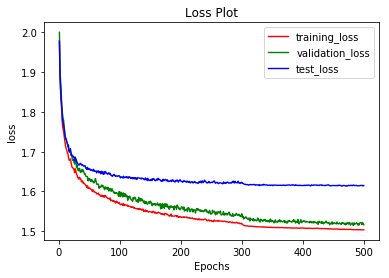

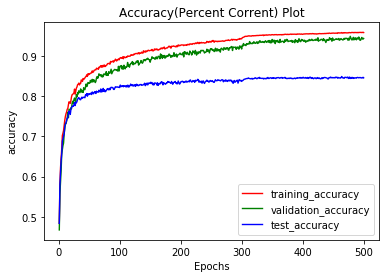

best valid_accuracy:  0.9486


In [10]:
loss = (trainstat[0], validstat[0], teststat[0])
accu = (trainstat[1], validstat[1], teststat[1])
plot_loss(loss)
plot_accu(accu)
print ('best valid_accuracy: ',np.max(validstat[1]))

In [6]:
class ConvNet1(nn.Module):
    def __init__(self, num_classes = 10):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, padding = 2)
        self.conv_bn1 = nn.BatchNorm2d(16)
        self.conv_blk1 = self._conv_block(16, 32)
        self.conv_blk_bn1 = nn.BatchNorm2d(32)
        self.conv_blk2 = self._conv_block(32, 32)
        self.conv_blk_bn2 = nn.BatchNorm2d(32)
        self.conv_blk3 = self._conv_block(32, 64)
        self.conv_blk_bn3 = nn.BatchNorm2d(64)
        self.conv_blk4 = self._conv_block(64, 64)
        self.conv_blk_bn4 = nn.BatchNorm2d(64)
        self.conv_blk5 = self._conv_block(64, 128)
        self.conv_blk_bn5 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avgpool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 1)
        
        
    def _conv_block(self, in_kernels, out_kernels):
        if in_kernels * 2 == out_kernels:
            stride = 2
        else:
            stride = 1
        block = nn.Sequential(
            nn.Conv2d(in_kernels, out_kernels, kernel_size = 3, padding = 1, stride = stride),
            nn.BatchNorm2d(out_kernels),
            nn.ReLU(),
            nn.Conv2d(out_kernels, out_kernels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_kernels),
            nn.ReLU(),
            nn.Conv2d(out_kernels, out_kernels, kernel_size = 1)
        )
        return block
        
    
    def initialize(self, method = None):
        if method is None:
            pass
        else:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    if method == 'fan-in':
                        fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
                elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    if method == 'fan-in':
                        fan_in = m.in_features
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.conv_bn1(x))
        x = self.conv_blk1(x)
        x = self.relu(self.conv_blk_bn1(x))
        x = self.conv_blk3(x)
        x = self.relu(self.conv_blk_bn3(x))
        x = self.conv_blk5(x)
        x = self.relu(self.conv_blk_bn5(x))
        x = self.avgpool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.softmax(self.fc1(x))
        return x
        

In [7]:
cnn1 = ConvNet1(num_classes = 10)
cnn1.initialize('Xavier')

if use_cuda:
    cnn1.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss()
    
# optimizer = optim.Adam(cnn1.parameters(), lr = 0.05)
optimizer = optim.SGD(cnn1.parameters(), lr = 0.01, momentum = 0.9)

epochs = 500

trainstat, validstat, teststat = training(cnn1, criterion, optimizer, 
                                          True, 300, 0.1, epochs, dataloaders, 
                                          use_cuda, model_dir = './model')

start training...
loading checkpoint './model/ConvNet1_ckpt.pth.tar'
loaded checkpoint './model/ConvNet1_ckpt.pth.tar' (epoch 392)
epoch: 393
train: 1.508  95.4%,   valid: 1.508  95.4%,   test: 1.588  87.2%
epoch: 394
train: 1.508  95.3%,   valid: 1.505  95.6%,   test: 1.590  87.1%
epoch: 395
train: 1.508  95.4%,   valid: 1.507  95.7%,   test: 1.588  87.3%
epoch: 396
train: 1.508  95.4%,   valid: 1.506  95.4%,   test: 1.589  87.1%
epoch: 397
train: 1.508  95.4%,   valid: 1.506  95.6%,   test: 1.589  87.1%
epoch: 398
train: 1.507  95.5%,   valid: 1.504  95.6%,   test: 1.588  87.2%
epoch: 399
train: 1.507  95.5%,   valid: 1.506  95.5%,   test: 1.588  87.2%
epoch: 400
train: 1.507  95.4%,   valid: 1.508  95.5%,   test: 1.589  87.2%
epoch: 401
train: 1.507  95.4%,   valid: 1.506  95.5%,   test: 1.588  87.2%
model saved.
epoch: 402
train: 1.507  95.5%,   valid: 1.504  95.7%,   test: 1.589  87.2%
epoch: 403
train: 1.507  95.4%,   valid: 1.502  96.0%,   test: 1.589  87.2%
model saved.
epoch: 

epoch: 497
train: 1.503  95.8%,   valid: 1.498  96.4%,   test: 1.586  87.4%
epoch: 498
train: 1.503  95.9%,   valid: 1.502  95.9%,   test: 1.586  87.5%
epoch: 499
train: 1.503  95.8%,   valid: 1.505  96.0%,   test: 1.587  87.4%
epoch: 500
train: 1.503  95.9%,   valid: 1.502  95.9%,   test: 1.587  87.5%
training finished.


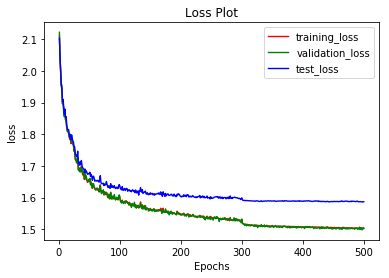

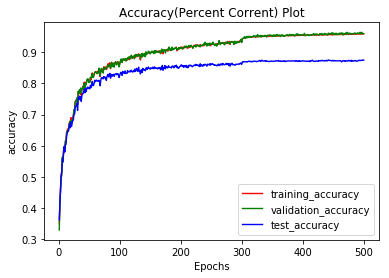

best valid_accuracy:  0.964


In [8]:
loss = (trainstat[0], validstat[0], teststat[0])
accu = (trainstat[1], validstat[1], teststat[1])
plot_loss(loss)
plot_accu(accu)
print ('best valid_accuracy: ',np.max(validstat[1]))

In [ ]:
# run in wda
'''
class Res_Conv_Net(nn.Module):
    def __init__(self, num_classes = 10):
        super(Res_Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, padding = 2)
        self.conv_bn1 = nn.BatchNorm2d(16)
        self.conv_blk1 = self._conv_block(16, 32)
        self.conv_blk_bn1 = nn.BatchNorm2d(32)
        self.conv_id1 = nn.Conv2d(16, 32, kernel_size = 1, stride = 2)
        self.conv_blk2 = self._conv_block(32, 32)
        self.conv_blk_bn2 = nn.BatchNorm2d(32)
        self.conv_id2 = nn.Conv2d(32, 32, kernel_size = 1)
        self.conv_blk3 = self._conv_block(32, 64)
        self.conv_blk_bn3 = nn.BatchNorm2d(64)
        self.conv_id3 = nn.Conv2d(32, 64, kernel_size = 1, stride = 2)
        self.conv_blk4 = self._conv_block(64, 64)
        self.conv_blk_bn4 = nn.BatchNorm2d(64)
        self.conv_id4 = nn.Conv2d(64, 64, kernel_size = 1)
        self.conv_blk5 = self._conv_block(64, 128)
        self.conv_blk_bn5 = nn.BatchNorm2d(128)
        self.conv_id5 = nn.Conv2d(64, 128, kernel_size = 1, stride = 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avgpool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 1)
        
        
    def _conv_block(self, in_kernels, out_kernels):
        if in_kernels * 2 == out_kernels:
            stride = 2
        else:
            stride = 1
        block = nn.Sequential(
            nn.Conv2d(in_kernels, out_kernels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d(out_kernels),
            nn.ReLU(),
            nn.Conv2d(out_kernels, out_kernels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_kernels),
            nn.ReLU(),
            nn.Conv2d(out_kernels, out_kernels, kernel_size = 1)
        )
        return block
        
    
    def initialize(self, method = None):
        if method is None:
            pass
        else:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    if method == 'fan-in':
                        fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
                elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    if method == 'fan-in':
                        fan_in = m.in_features
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
            
    def forward(self, x):
        x = self.conv_bn1(self.conv1(x))
        x = self.relu(x)
        x_id = self.conv_id1(x)
        x = self.conv_blk_bn1(self.conv_blk1(x))             # 16 to 32 kernels, stride = 2
        x = x + x_id
        x = self.relu(x)
        x_id = self.conv_id2(x)
        x = self.conv_blk_bn2(self.conv_blk2(x))             # 32 to 32 kernels, stride = 1
        x = x + x_id
        x = self.relu(x)
        x_id = self.conv_id3(x)
        x = self.conv_blk_bn3(self.conv_blk3(x))             # 32 to 64 kernels, stride = 2
        x = x + x_id
        x = self.relu(x)
        x_id = self.conv_id4(x)
        x = self.conv_blk_bn4(self.conv_blk4(x))             # 64 to 64 kernels, stride = 1
        x = x + x_id
        x = self.relu(x)
        x_id = self.conv_id5(x)
        x = self.conv_blk_bn5(self.conv_blk5(x))             # 64 to 128 kernels, stride = 2
        x = x + x_id
        x = self.relu(x)
        x = self.avgpool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.softmax(self.fc1(x))
        return x
'''

In [ ]:
# run in wda
'''
cnn2 = ConvNet2(num_classes = 10)
cnn2.initialize('Xavier')

if use_cuda:
    cnn2.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.Adam(cnn2.parameters(), lr = 0.1)

epochs = 500

trainstat, validstat, teststat = training(cnn1, criterion, optimizer, lr_decay, epochs, dataloaders, use_cuda)
'''

In [5]:
# run in wbe
# a stochastic depth version of the above variant of ResNet
# run in wda
# a stochastic depth version of the above variant of ResNet
class Sdep_Res_Conv_Net(nn.Module):
    def __init__(self, num_classes = 10):
        super(Sdep_Res_Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, padding = 2)
        self.conv_bn1 = nn.BatchNorm2d(16)
        self.conv_blk1 = self._conv_block(16, 32)
        self.conv_blk_bn1 = nn.BatchNorm2d(32)
        self.conv_id1 = nn.Conv2d(16, 32, kernel_size = 1, stride = 2)
        self.conv_blk2 = self._conv_block(32, 32)
        self.conv_blk_bn2 = nn.BatchNorm2d(32)
        self.conv_id2 = nn.Conv2d(32, 32, kernel_size = 1)
        self.conv_blk3 = self._conv_block(32, 64)
        self.conv_blk_bn3 = nn.BatchNorm2d(64)
        self.conv_id3 = nn.Conv2d(32, 64, kernel_size = 1, stride = 2)
        self.conv_blk4 = self._conv_block(64, 64)
        self.conv_blk_bn4 = nn.BatchNorm2d(64)
        self.conv_id4 = nn.Conv2d(64, 64, kernel_size = 1)
        self.conv_blk5 = self._conv_block(64, 64)
        self.conv_blk_bn5 = nn.BatchNorm2d(64)
        self.conv_id5 = nn.Conv2d(64, 64, kernel_size = 1)
        self.conv_blk6 = self._conv_block(64, 128)
        self.conv_blk_bn6 = nn.BatchNorm2d(128)
        self.conv_id6 = nn.Conv2d(64, 128, kernel_size = 1, stride = 2)
        self.conv_blk7 = self._conv_block(128, 128)
        self.conv_blk_bn7 = nn.BatchNorm2d(128)
        self.conv_id7 = nn.Conv2d(128, 128, kernel_size = 1)
        self.conv_blk8 = self._conv_block(128, 128)
        self.conv_blk_bn8 = nn.BatchNorm2d(128)
        self.conv_id8 = nn.Conv2d(128, 128, kernel_size = 1)
        self.fc1 = nn.Linear(128 * 4 * 4, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avgpool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 1)
        self.p = torch.linspace(start = 1., end = 0.5, steps = 5)
        
        
    def _conv_block(self, in_kernels, out_kernels):
        if in_kernels * 2 == out_kernels:
            stride = 2
        else:
            stride = 1
        block = nn.Sequential(
            nn.Conv2d(in_kernels, out_kernels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d(out_kernels),
            nn.ReLU(),
            nn.Conv2d(out_kernels, out_kernels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_kernels),
            nn.ReLU(),
            nn.Conv2d(out_kernels, out_kernels, kernel_size = 1)
        )
        return block
        
    
    def initialize(self, method = None):
        if method is None:
            pass
        else:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    if method == 'fan-in':
                        fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
                elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    if method == 'fan-in':
                        fan_in = m.in_features
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
            
    def forward(self, x):
        if self.training:
            self.active = torch.bernoulli(self.p)
#             print ('num of active blocks:', int(torch.sum(self.active)))
            x = self.conv_bn1(self.conv1(x))
            x = self.relu(x)
            x_id = self.conv_id1(x)
            x = self.active[0] * self.conv_blk_bn1(self.conv_blk1(x))             # 16 to 32 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
#             x_id = self.conv_id2(x)
#             x = self.active[1] * self.conv_blk_bn2(self.conv_blk2(x))             # 32 to 32 kernels, stride = 1
#             x = x + x_id
#             x = self.relu(x)
            x_id = self.conv_id3(x)
            x = self.active[1] * self.conv_blk_bn3(self.conv_blk3(x))             # 32 to 64 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
#             x_id = self.conv_id4(x)
#             x = self.active[3] * self.conv_blk_bn4(self.conv_blk4(x))             # 64 to 64 kernels, stride = 1
#             x = x + x_id
#             x = self.relu(x)
            x_id = self.conv_id5(x)
            x = self.active[2] * self.conv_blk_bn5(self.conv_blk5(x))             # 64 to 64 kernels, stride = 1
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id6(x)
            x = self.active[3] * self.conv_blk_bn6(self.conv_blk6(x))             # 64 to 128 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id7(x)
            x = self.active[4] * self.conv_blk_bn7(self.conv_blk7(x))             # 128 to 128 kernels, stride = 1
            x = x + x_id
            x = self.relu(x)
#             x_id = self.conv_id8(x)
#             x = self.active[7] * self.conv_blk_bn8(self.conv_blk8(x))             # 128 to 128 kernels, stride = 1
#             x = x + x_id
#             x = self.relu(x)
            x = self.avgpool(x)
            x = x.view(-1, 128 * 4 * 4)
            x = F.softmax(self.fc1(x))
        else:
            x = self.conv_bn1(self.conv1(x))
            x = self.relu(x)
            x_id = self.conv_id1(x)
            x = self.p[0] * self.conv_blk_bn1(self.conv_blk1(x))             # 16 to 32 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
#             x_id = self.conv_id2(x)
#             x = self.p[1] * self.conv_blk_bn2(self.conv_blk2(x))             # 32 to 32 kernels, stride = 1
#             x = x + x_id
#             x = self.relu(x)
            x_id = self.conv_id3(x)
            x = self.p[1] * self.conv_blk_bn3(self.conv_blk3(x))             # 32 to 64 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
#             x_id = self.conv_id4(x)
#             x = self.p[3] * self.conv_blk_bn4(self.conv_blk4(x))             # 64 to 64 kernels, stride = 1
#             x = x + x_id
#             x = self.relu(x)
            x_id = self.conv_id5(x)
            x = self.p[2] * self.conv_blk_bn5(self.conv_blk5(x))             # 64 to 64 kernels, stride = 1
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id6(x)
            x = self.p[3] * self.conv_blk_bn6(self.conv_blk6(x))             # 64 to 128 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id7(x)
            x = self.p[4] * self.conv_blk_bn7(self.conv_blk7(x))             # 128 to 128 kernels, stride = 1
            x = x + x_id
            x = self.relu(x)
#             x_id = self.conv_id8(x)
#             x = self.p[7] * self.conv_blk_bn8(self.conv_blk8(x))             # 128 to 128 kernels, stride = 1
#             x = x + x_id
#             x = self.relu(x)
            x = self.avgpool(x)
            x = x.view(-1, 128 * 4 * 4)
            x = F.softmax(self.fc1(x))
        return x

In [9]:
# stochastic depth ResNet with exponential decay each 10 epoch, gamma = 0.9
cnn3 = Sdep_Res_Conv_Net(num_classes = 10)
cnn3.initialize('Xavier')

if use_cuda:
    cnn3.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss()
    
# optimizer = optim.Adam(cnn3.parameters(), lr = 0.01)
optimizer = optim.SGD(cnn3.parameters(), lr = 0.01, momentum = 0.9)
# optimizer = optim.ASGD(cnn3.parameters())

epochs = 500

trainstat, validstat, teststat = training(cnn3, criterion, optimizer, epochs, dataloaders, 
                                          [250, 350, 400], 0.5, use_cuda)
# def training(model, criterion, optimizer, epochs, dataloaders, step_size = None, 
#              gamma = None, use_cuda = False, model_dir = None, best_model = False):

start training...
epoch: 1
train: 2.185  25.5%,   valid: 2.186  25.0%,   test: 2.186  25.2%
model saved.
epoch: 2
train: 2.151  30.2%,   valid: 2.155  29.6%,   test: 2.149  30.1%
model saved.
epoch: 3
train: 2.082  37.2%,   valid: 2.096  35.3%,   test: 2.083  37.1%
model saved.
epoch: 4
train: 2.078  37.7%,   valid: 2.072  37.8%,   test: 2.075  37.6%
model saved.
epoch: 5
train: 2.050  40.5%,   valid: 2.052  39.5%,   test: 2.047  40.7%
model saved.
epoch: 6
train: 2.045  41.1%,   valid: 2.047  40.1%,   test: 2.039  41.4%
model saved.
epoch: 7
train: 2.028  42.6%,   valid: 2.029  42.3%,   test: 2.022  43.5%
model saved.
epoch: 8
train: 2.054  40.3%,   valid: 2.052  40.2%,   test: 2.055  40.0%
epoch: 9
train: 1.994  46.2%,   valid: 2.004  44.8%,   test: 1.998  45.5%
model saved.
epoch: 10
train: 2.000  45.6%,   valid: 1.997  45.1%,   test: 1.999  45.9%
model saved.
epoch: 11
train: 1.980  47.8%,   valid: 1.983  46.9%,   test: 1.982  47.5%
model saved.
epoch: 12
train: 1.965  49.3%,   val

epoch: 102
train: 1.722  73.8%,   valid: 1.715  74.5%,   test: 1.738  72.1%
epoch: 103
train: 1.688  77.2%,   valid: 1.686  76.8%,   test: 1.705  75.5%
epoch: 104
train: 1.713  74.7%,   valid: 1.717  74.2%,   test: 1.726  73.3%
epoch: 105
train: 1.732  72.7%,   valid: 1.742  72.2%,   test: 1.743  71.7%
epoch: 106
train: 1.701  75.9%,   valid: 1.702  76.3%,   test: 1.717  74.3%
epoch: 107
train: 1.685  77.5%,   valid: 1.684  77.5%,   test: 1.700  75.9%
model saved.
epoch: 108
train: 1.694  76.6%,   valid: 1.689  76.4%,   test: 1.708  75.0%
epoch: 109
train: 1.725  73.4%,   valid: 1.728  72.8%,   test: 1.738  72.2%
epoch: 110
train: 1.693  76.7%,   valid: 1.682  77.7%,   test: 1.706  75.2%
model saved.
epoch: 111
train: 1.705  75.5%,   valid: 1.698  75.9%,   test: 1.720  74.0%
model saved.
epoch: 112
train: 1.693  76.7%,   valid: 1.693  76.3%,   test: 1.706  75.5%
epoch: 113
train: 1.681  77.9%,   valid: 1.672  78.6%,   test: 1.698  76.2%
model saved.
epoch: 114
train: 1.680  78.0%,   va

epoch: 206
train: 1.639  82.1%,   valid: 1.639  82.1%,   test: 1.660  80.0%
epoch: 207
train: 1.639  82.1%,   valid: 1.629  82.9%,   test: 1.659  80.1%
model saved.
epoch: 208
train: 1.639  82.2%,   valid: 1.628  83.1%,   test: 1.657  80.2%
model saved.
epoch: 209
train: 1.648  81.2%,   valid: 1.648  81.0%,   test: 1.665  79.5%
epoch: 210
train: 1.647  81.3%,   valid: 1.640  82.1%,   test: 1.664  79.5%
epoch: 211
train: 1.638  82.2%,   valid: 1.640  82.3%,   test: 1.654  80.6%
model saved.
epoch: 212
train: 1.629  83.2%,   valid: 1.628  83.3%,   test: 1.650  80.9%
model saved.
epoch: 213
train: 1.631  83.0%,   valid: 1.622  83.4%,   test: 1.652  80.7%
model saved.
epoch: 214
train: 1.639  82.2%,   valid: 1.638  82.3%,   test: 1.660  80.0%
epoch: 215
train: 1.635  82.6%,   valid: 1.629  82.6%,   test: 1.654  80.4%
epoch: 216
train: 1.642  81.8%,   valid: 1.641  82.1%,   test: 1.662  79.9%
epoch: 217
train: 1.634  82.7%,   valid: 1.636  82.4%,   test: 1.650  81.0%
epoch: 218
train: 1.640

epoch: 310
train: 1.597  86.4%,   valid: 1.591  86.7%,   test: 1.627  83.4%
epoch: 311
train: 1.596  86.5%,   valid: 1.598  86.2%,   test: 1.628  83.1%
model saved.
epoch: 312
train: 1.594  86.6%,   valid: 1.595  86.5%,   test: 1.623  83.7%
epoch: 313
train: 1.593  86.8%,   valid: 1.593  86.9%,   test: 1.621  83.9%
epoch: 314
train: 1.596  86.5%,   valid: 1.591  86.7%,   test: 1.625  83.4%
epoch: 315
train: 1.597  86.4%,   valid: 1.599  85.7%,   test: 1.630  83.0%
epoch: 316
train: 1.593  86.8%,   valid: 1.593  86.6%,   test: 1.624  83.7%
epoch: 317
train: 1.594  86.7%,   valid: 1.594  86.6%,   test: 1.625  83.5%
epoch: 318
train: 1.601  85.9%,   valid: 1.602  85.9%,   test: 1.631  82.9%
epoch: 319
train: 1.592  86.8%,   valid: 1.594  87.0%,   test: 1.626  83.4%
epoch: 320
train: 1.591  87.0%,   valid: 1.587  87.3%,   test: 1.620  84.0%
epoch: 321
train: 1.593  86.7%,   valid: 1.591  87.0%,   test: 1.623  83.7%
model saved.
epoch: 322
train: 1.589  87.2%,   valid: 1.595  86.5%,   test:

epoch: 415
train: 1.570  89.1%,   valid: 1.566  89.6%,   test: 1.607  85.4%
epoch: 416
train: 1.569  89.2%,   valid: 1.570  89.1%,   test: 1.605  85.6%
epoch: 417
train: 1.568  89.2%,   valid: 1.561  89.8%,   test: 1.605  85.5%
epoch: 418
train: 1.566  89.4%,   valid: 1.568  89.1%,   test: 1.604  85.6%
epoch: 419
train: 1.570  89.1%,   valid: 1.571  89.0%,   test: 1.604  85.7%
epoch: 420
train: 1.566  89.4%,   valid: 1.567  89.7%,   test: 1.603  85.7%
epoch: 421
train: 1.568  89.3%,   valid: 1.562  89.6%,   test: 1.604  85.6%
model saved.
epoch: 422
train: 1.567  89.4%,   valid: 1.567  89.1%,   test: 1.604  85.5%
epoch: 423
train: 1.568  89.3%,   valid: 1.563  89.6%,   test: 1.605  85.6%
epoch: 424
train: 1.565  89.6%,   valid: 1.569  89.3%,   test: 1.603  85.6%
epoch: 425
train: 1.567  89.4%,   valid: 1.561  89.8%,   test: 1.606  85.5%
epoch: 426
train: 1.566  89.5%,   valid: 1.566  89.5%,   test: 1.603  85.7%
epoch: 427
train: 1.566  89.5%,   valid: 1.567  89.5%,   test: 1.606  85.5%

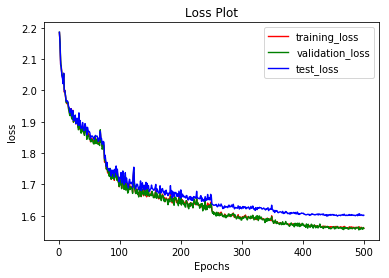

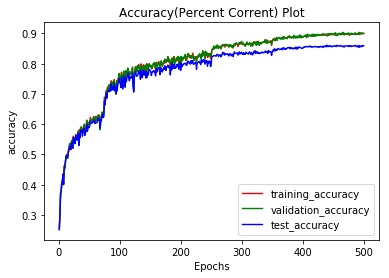

best valid_accuracy:  0.904


In [10]:
loss = (trainstat[0], validstat[0], teststat[0])
accu = (trainstat[1], validstat[1], teststat[1])
plot_loss(loss)
plot_accu(accu)
print ('best valid_accuracy: ',np.max(validstat[1]))

In [6]:
# a shallow version of above model
cnn4 = Sdep_Res_Conv_Net(num_classes = 10)
cnn4.initialize('Xavier')

if use_cuda:
    cnn4.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss()
    
# optimizer = optim.Adam(cnn3.parameters(), lr = 0.01)
optimizer = optim.SGD(cnn4.parameters(), lr = 0.01, momentum = 0.9)
# optimizer = optim.ASGD(cnn3.parameters())

epochs = 500

trainstat, validstat, teststat = training(cnn4, criterion, optimizer, epochs, dataloaders, 
                                          [250, 350, 400], 0.5, use_cuda)

start training...
epoch: 1
train: 2.175  27.8%,   valid: 2.170  28.3%,   test: 2.175  28.1%
model saved.
epoch: 2
train: 2.134  32.0%,   valid: 2.126  32.8%,   test: 2.132  32.3%
model saved.
epoch: 3
train: 2.120  33.1%,   valid: 2.132  31.7%,   test: 2.119  33.1%
epoch: 4
train: 2.063  39.2%,   valid: 2.054  39.6%,   test: 2.063  39.1%
model saved.
epoch: 5
train: 2.033  42.3%,   valid: 2.034  41.6%,   test: 2.027  43.0%
model saved.
epoch: 6
train: 2.049  40.7%,   valid: 2.046  40.3%,   test: 2.039  41.5%
epoch: 7
train: 1.984  47.3%,   valid: 1.981  47.0%,   test: 1.985  47.0%
model saved.
epoch: 8
train: 1.994  46.4%,   valid: 1.982  46.9%,   test: 1.991  46.8%
epoch: 9
train: 1.981  47.6%,   valid: 1.980  47.1%,   test: 1.981  47.6%
model saved.
epoch: 10
train: 1.991  46.5%,   valid: 1.995  45.6%,   test: 1.992  46.5%
epoch: 11
train: 1.979  47.8%,   valid: 1.970  48.1%,   test: 1.978  47.8%
model saved.
epoch: 12
train: 1.978  47.9%,   valid: 1.967  48.3%,   test: 1.982  47.6%


epoch: 103
train: 1.779  68.0%,   valid: 1.774  67.9%,   test: 1.795  66.3%
epoch: 104
train: 1.783  67.7%,   valid: 1.771  68.1%,   test: 1.796  66.3%
epoch: 105
train: 1.782  67.7%,   valid: 1.775  67.8%,   test: 1.794  66.5%
epoch: 106
train: 1.781  67.8%,   valid: 1.770  68.5%,   test: 1.791  66.7%
epoch: 107
train: 1.777  68.3%,   valid: 1.761  69.4%,   test: 1.791  66.8%
model saved.
epoch: 108
train: 1.780  67.9%,   valid: 1.771  68.2%,   test: 1.795  66.4%
epoch: 109
train: 1.781  67.9%,   valid: 1.772  68.1%,   test: 1.794  66.6%
epoch: 110
train: 1.786  67.4%,   valid: 1.773  67.9%,   test: 1.802  65.8%
epoch: 111
train: 1.775  68.4%,   valid: 1.774  67.8%,   test: 1.788  67.0%
model saved.
epoch: 112
train: 1.774  68.5%,   valid: 1.764  69.2%,   test: 1.789  67.1%
epoch: 113
train: 1.795  66.4%,   valid: 1.788  66.4%,   test: 1.811  64.9%
epoch: 114
train: 1.774  68.6%,   valid: 1.766  68.8%,   test: 1.787  67.1%
epoch: 115
train: 1.778  68.1%,   valid: 1.770  68.5%,   test:

epoch: 206
train: 1.684  77.6%,   valid: 1.681  77.3%,   test: 1.710  75.0%
epoch: 207
train: 1.685  77.5%,   valid: 1.681  77.7%,   test: 1.713  74.7%
epoch: 208
train: 1.686  77.4%,   valid: 1.682  77.2%,   test: 1.711  75.1%
epoch: 209
train: 1.685  77.5%,   valid: 1.684  77.6%,   test: 1.711  75.0%
epoch: 210
train: 1.689  77.1%,   valid: 1.679  77.6%,   test: 1.713  74.8%
epoch: 211
train: 1.682  77.8%,   valid: 1.676  77.9%,   test: 1.705  75.5%
model saved.
epoch: 212
train: 1.686  77.5%,   valid: 1.679  77.6%,   test: 1.715  74.6%
epoch: 213
train: 1.687  77.3%,   valid: 1.678  77.7%,   test: 1.707  75.4%
epoch: 214
train: 1.684  77.6%,   valid: 1.679  77.9%,   test: 1.704  75.6%
epoch: 215
train: 1.681  77.9%,   valid: 1.676  77.9%,   test: 1.704  75.7%
epoch: 216
train: 1.691  77.0%,   valid: 1.689  76.8%,   test: 1.714  74.7%
epoch: 217
train: 1.689  77.1%,   valid: 1.681  77.5%,   test: 1.712  74.8%
epoch: 218
train: 1.683  77.8%,   valid: 1.676  77.7%,   test: 1.707  75.3%

epoch: 311
train: 1.650  81.1%,   valid: 1.646  80.9%,   test: 1.685  77.6%
model saved.
epoch: 312
train: 1.653  80.7%,   valid: 1.647  80.9%,   test: 1.686  77.4%
epoch: 313
train: 1.651  80.9%,   valid: 1.645  81.1%,   test: 1.684  77.6%
epoch: 314
train: 1.652  80.8%,   valid: 1.650  80.5%,   test: 1.687  77.4%
epoch: 315
train: 1.650  81.1%,   valid: 1.645  81.0%,   test: 1.687  77.4%
epoch: 316
train: 1.655  80.6%,   valid: 1.649  80.7%,   test: 1.691  77.0%
epoch: 317
train: 1.648  81.2%,   valid: 1.643  81.4%,   test: 1.685  77.5%
epoch: 318
train: 1.651  81.0%,   valid: 1.649  81.0%,   test: 1.686  77.5%
epoch: 319
train: 1.654  80.6%,   valid: 1.649  80.7%,   test: 1.687  77.2%
epoch: 320
train: 1.656  80.5%,   valid: 1.647  81.0%,   test: 1.688  77.2%
epoch: 321
train: 1.650  81.0%,   valid: 1.644  81.2%,   test: 1.682  77.9%
model saved.
epoch: 322
train: 1.650  81.1%,   valid: 1.647  80.9%,   test: 1.686  77.5%
epoch: 323
train: 1.649  81.1%,   valid: 1.650  80.8%,   test:

epoch: 415
train: 1.635  82.6%,   valid: 1.629  82.7%,   test: 1.678  78.2%
epoch: 416
train: 1.634  82.7%,   valid: 1.628  82.9%,   test: 1.677  78.4%
epoch: 417
train: 1.634  82.7%,   valid: 1.628  82.8%,   test: 1.676  78.5%
epoch: 418
train: 1.635  82.6%,   valid: 1.632  82.5%,   test: 1.677  78.3%
epoch: 419
train: 1.635  82.6%,   valid: 1.630  82.7%,   test: 1.676  78.4%
epoch: 420
train: 1.635  82.6%,   valid: 1.628  82.9%,   test: 1.676  78.4%
epoch: 421
train: 1.634  82.6%,   valid: 1.630  82.6%,   test: 1.677  78.2%
model saved.
epoch: 422
train: 1.634  82.7%,   valid: 1.635  82.4%,   test: 1.677  78.4%
epoch: 423
train: 1.635  82.6%,   valid: 1.634  82.2%,   test: 1.676  78.5%
epoch: 424
train: 1.635  82.6%,   valid: 1.628  82.9%,   test: 1.678  78.4%
epoch: 425
train: 1.634  82.6%,   valid: 1.630  82.7%,   test: 1.676  78.5%
epoch: 426
train: 1.634  82.6%,   valid: 1.630  82.6%,   test: 1.677  78.4%
epoch: 427
train: 1.633  82.8%,   valid: 1.631  82.6%,   test: 1.677  78.5%

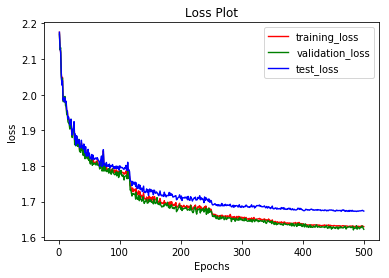

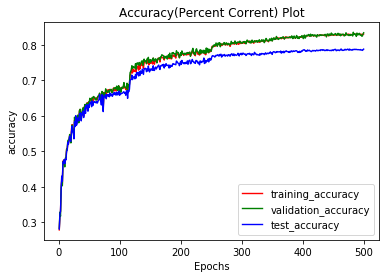

best valid_accuracy:  0.8358


In [7]:
loss = (trainstat[0], validstat[0], teststat[0])
accu = (trainstat[1], validstat[1], teststat[1])
plot_loss(loss)
plot_accu(accu)
print ('best valid_accuracy: ',np.max(validstat[1]))

In [10]:
class Sdep_Res_Conv_Net2(nn.Module):
    def __init__(self, num_classes = 10):
        super(Sdep_Res_Conv_Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 5, padding = 2)
        self.conv_bn1 = nn.BatchNorm2d(32)
        self.conv_blk1 = self._BottleNeck(32, 64)
        self.conv_id1 = nn.Conv2d(32, 64, kernel_size = 1, stride = 2)
        self.conv_blk2 = self._BottleNeck(64, 64)
        self.conv_id2 = nn.Conv2d(64, 64, kernel_size = 1)
        self.conv_blk3 = self._BottleNeck(64, 128)
        self.conv_id3 = nn.Conv2d(64, 128, kernel_size = 1, stride = 2)
        self.conv_blk4 = self._BottleNeck(128, 128)
        self.conv_id4 = nn.Conv2d(128, 128, kernel_size = 1)
        self.conv_blk5 = self._BottleNeck(128, 256)
        self.conv_id5 = nn.Conv2d(128, 256, kernel_size = 1, stride = 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avgpool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 1)
        self.p = torch.linspace(start = 1., end = 0.5, steps = 5)
        
        
    def _BottleNeck(self, in_kernels, out_kernels):
        if in_kernels * 2 == out_kernels:
            stride = 2
        else:
            stride = 1
        ite_kernels = int(in_kernels / 2)
        bottleneck = nn.Sequential(
            nn.Conv2d(in_kernels, ite_kernels, kernel_size = 1),
            nn.BatchNorm2d(ite_kernels),
            nn.ReLU(),
            nn.Conv2d(ite_kernels, ite_kernels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d(ite_kernels),
            nn.ReLU(),
            nn.Conv2d(ite_kernels, out_kernels, kernel_size = 1),
            nn.BatchNorm2d(out_kernels)
        )
        return bottleneck
        
    
    def initialize(self, method = None):
        if method is None:
            pass
        else:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    if method == 'fan-in':
                        fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
                elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    if method == 'fan-in':
                        fan_in = m.in_features
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
            
    def forward(self, x):
        if self.training:
            self.active = torch.bernoulli(self.p)
            x = self.conv_bn1(self.conv1(x))
            x = self.relu(x)
            x_id = self.conv_id1(x)
            x = self.active[0] * self.conv_blk1(x)             # 16 to 32 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id2(x)
            x = self.active[1] * self.conv_blk2(x)             # 32 to 32 kernels, stride = 1
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id3(x)
            x = self.active[2] * self.conv_blk3(x)             # 32 to 64 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id4(x)
            x = self.active[3] * self.conv_blk4(x)             # 64 to 64 kernels, stride = 1
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id5(x)
            x = self.active[4] * self.conv_blk5(x)             # 64 to 128 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
            x = self.avgpool(x)
            x = x.view(-1, 256 * 4 * 4)
            x = F.softmax(self.fc1(x))
        else:
            x = self.conv_bn1(self.conv1(x))
            x = self.relu(x)
            x_id = self.conv_id1(x)
            x = self.p[0] * self.conv_blk1(x)             # 16 to 32 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id2(x)
            x = self.p[1] * self.conv_blk2(x)             # 32 to 32 kernels, stride = 1
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id3(x)
            x = self.p[2] * self.conv_blk3(x)             # 32 to 64 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id4(x)
            x = self.p[3] * self.conv_blk4(x)             # 64 to 64 kernels, stride = 1
            x = x + x_id
            x = self.relu(x)
            x_id = self.conv_id5(x)
            x = self.p[4] * self.conv_blk5(x)             # 64 to 128 kernels, stride = 2
            x = x + x_id
            x = self.relu(x)
            x = self.avgpool(x)
            x = x.view(-1, 256 * 4 * 4)
            x = F.softmax(self.fc1(x))
        return x

In [11]:
cnn6 = Sdep_Res_Conv_Net2(num_classes = 10)
cnn6.initialize('Xavier')

if use_cuda:
    cnn6.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss()
    
# optimizer = optim.Adam(cnn3.parameters(), lr = 0.01)
optimizer = optim.SGD(cnn6.parameters(), lr = 0.01, momentum = 0.9)
# optimizer = optim.ASGD(cnn3.parameters())

epochs = 500

trainstat, validstat, teststat = training(cnn6, criterion, optimizer, epochs, dataloaders, 
                                          [250, 350, 400], 0.5, use_cuda)

start training...
epoch: 1
train: 2.146  30.4%,   valid: 2.153  29.4%,   test: 2.142  30.8%
model saved.
epoch: 2
train: 2.102  35.1%,   valid: 2.108  34.4%,   test: 2.092  36.4%
model saved.
epoch: 3
train: 2.098  35.6%,   valid: 2.097  35.7%,   test: 2.093  36.1%
model saved.
epoch: 4
train: 2.052  40.3%,   valid: 2.060  38.9%,   test: 2.048  40.7%
model saved.
epoch: 5
train: 2.051  40.4%,   valid: 2.063  39.1%,   test: 2.048  40.7%
model saved.
epoch: 6
train: 2.045  41.0%,   valid: 2.051  40.0%,   test: 2.043  41.2%
model saved.
epoch: 7
train: 2.025  43.0%,   valid: 2.021  43.5%,   test: 2.023  43.2%
model saved.
epoch: 8
train: 1.997  46.0%,   valid: 2.008  44.6%,   test: 1.999  45.7%
model saved.
epoch: 9
train: 1.993  46.3%,   valid: 2.011  44.3%,   test: 1.997  45.9%
epoch: 10
train: 1.995  46.2%,   valid: 2.002  44.9%,   test: 1.994  46.2%
model saved.
epoch: 11
train: 1.966  49.1%,   valid: 1.981  46.9%,   test: 1.970  48.9%
model saved.
epoch: 12
train: 1.957  50.0%,   val

epoch: 103
train: 1.762  69.8%,   valid: 1.766  69.0%,   test: 1.778  67.9%
epoch: 104
train: 1.757  70.2%,   valid: 1.760  69.5%,   test: 1.768  69.1%
epoch: 105
train: 1.750  71.0%,   valid: 1.752  70.3%,   test: 1.759  69.9%
model saved.
epoch: 106
train: 1.767  69.2%,   valid: 1.768  69.1%,   test: 1.782  67.6%
epoch: 107
train: 1.760  70.0%,   valid: 1.760  69.9%,   test: 1.769  68.8%
epoch: 108
train: 1.749  71.0%,   valid: 1.748  70.7%,   test: 1.761  69.7%
model saved.
epoch: 109
train: 1.753  70.7%,   valid: 1.756  70.3%,   test: 1.767  68.9%
epoch: 110
train: 1.758  70.2%,   valid: 1.766  69.2%,   test: 1.770  68.7%
epoch: 111
train: 1.755  70.4%,   valid: 1.754  70.3%,   test: 1.767  69.1%
model saved.
epoch: 112
train: 1.767  69.2%,   valid: 1.763  69.2%,   test: 1.774  68.4%
epoch: 113
train: 1.751  70.8%,   valid: 1.755  70.2%,   test: 1.759  70.0%
epoch: 114
train: 1.753  70.7%,   valid: 1.747  70.8%,   test: 1.764  69.7%
model saved.
epoch: 115
train: 1.755  70.5%,   va

epoch: 208
train: 1.710  75.1%,   valid: 1.712  74.6%,   test: 1.728  73.1%
epoch: 209
train: 1.712  74.8%,   valid: 1.711  75.0%,   test: 1.727  73.4%
model saved.
epoch: 210
train: 1.715  74.6%,   valid: 1.715  74.4%,   test: 1.732  72.8%
epoch: 211
train: 1.709  75.1%,   valid: 1.710  75.0%,   test: 1.722  73.8%
model saved.
epoch: 212
train: 1.716  74.4%,   valid: 1.714  74.4%,   test: 1.731  73.0%
epoch: 213
train: 1.714  74.7%,   valid: 1.720  74.0%,   test: 1.728  73.3%
epoch: 214
train: 1.707  75.3%,   valid: 1.711  74.5%,   test: 1.724  73.5%
epoch: 215
train: 1.713  74.6%,   valid: 1.714  74.4%,   test: 1.727  73.2%
epoch: 216
train: 1.706  75.4%,   valid: 1.709  74.7%,   test: 1.724  73.7%
epoch: 217
train: 1.706  75.5%,   valid: 1.702  75.4%,   test: 1.723  73.6%
model saved.
epoch: 218
train: 1.713  74.7%,   valid: 1.718  74.1%,   test: 1.733  72.6%
epoch: 219
train: 1.707  75.3%,   valid: 1.712  74.5%,   test: 1.723  73.8%
epoch: 220
train: 1.707  75.4%,   valid: 1.712  7

epoch: 313
train: 1.680  78.1%,   valid: 1.681  77.7%,   test: 1.704  75.4%
epoch: 314
train: 1.679  78.1%,   valid: 1.676  77.9%,   test: 1.705  75.4%
epoch: 315
train: 1.681  78.0%,   valid: 1.680  77.8%,   test: 1.702  75.7%
epoch: 316
train: 1.679  78.2%,   valid: 1.679  77.8%,   test: 1.702  75.8%
epoch: 317
train: 1.679  78.2%,   valid: 1.682  77.8%,   test: 1.699  76.2%
epoch: 318
train: 1.681  77.9%,   valid: 1.677  77.9%,   test: 1.704  75.5%
epoch: 319
train: 1.680  78.0%,   valid: 1.680  77.7%,   test: 1.704  75.5%
epoch: 320
train: 1.685  77.5%,   valid: 1.686  77.1%,   test: 1.705  75.4%
epoch: 321
train: 1.676  78.4%,   valid: 1.678  77.9%,   test: 1.697  76.2%
model saved.
epoch: 322
train: 1.682  77.8%,   valid: 1.682  77.7%,   test: 1.706  75.2%
epoch: 323
train: 1.677  78.4%,   valid: 1.679  78.0%,   test: 1.699  76.0%
epoch: 324
train: 1.677  78.3%,   valid: 1.672  78.4%,   test: 1.698  76.1%
model saved.
epoch: 325
train: 1.680  78.0%,   valid: 1.680  77.7%,   test:

epoch: 419
train: 1.662  79.9%,   valid: 1.663  79.6%,   test: 1.693  76.6%
epoch: 420
train: 1.664  79.6%,   valid: 1.665  79.0%,   test: 1.692  76.8%
epoch: 421
train: 1.663  79.7%,   valid: 1.657  79.9%,   test: 1.690  77.0%
model saved.
epoch: 422
train: 1.662  79.9%,   valid: 1.663  79.6%,   test: 1.689  77.0%
epoch: 423
train: 1.664  79.7%,   valid: 1.664  79.4%,   test: 1.692  76.8%
epoch: 424
train: 1.664  79.7%,   valid: 1.661  79.5%,   test: 1.691  76.9%
epoch: 425
train: 1.663  79.8%,   valid: 1.661  79.4%,   test: 1.691  76.8%
epoch: 426
train: 1.665  79.5%,   valid: 1.663  79.7%,   test: 1.693  76.6%
epoch: 427
train: 1.662  79.8%,   valid: 1.663  79.7%,   test: 1.691  76.8%
epoch: 428
train: 1.663  79.7%,   valid: 1.662  79.3%,   test: 1.692  76.7%
epoch: 429
train: 1.662  79.8%,   valid: 1.663  79.6%,   test: 1.692  76.7%
epoch: 430
train: 1.663  79.7%,   valid: 1.661  79.6%,   test: 1.691  76.6%
epoch: 431
train: 1.664  79.7%,   valid: 1.667  79.1%,   test: 1.690  76.9%

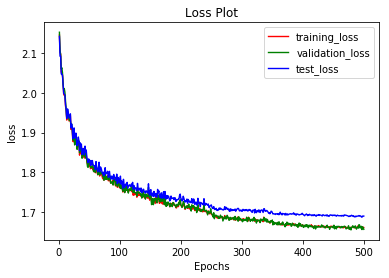

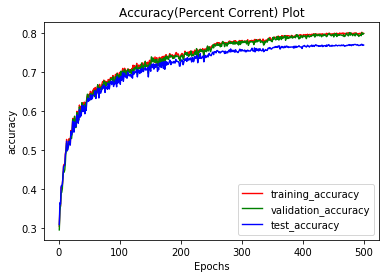

best valid_accuracy:  0.8018


In [14]:
loss = (trainstat[0], validstat[0], teststat[0])
accu = (trainstat[1], validstat[1], teststat[1])
plot_loss(loss)
plot_accu(accu)
print ('best valid_accuracy: ',np.max(validstat[1]))